# Simple Unet Model to Segment a Single Malignancy from Mammograms

### Using TensorFlow Input Pipeline

| Class               | Grayscale Value | Color Name | RGB Value        |
|---------------------|-----------------|------------|------------------|
| `background`        | `0` - 0.              | black      | `RGB (0, 0, 0)`  |
| `malignant_mass`    | `76` - 1.            | red        | `RGB (255, 0, 0)`|
| `benign_mass`       | `149` - 2.           | green      | `RGB (0, 255, 0)`|
| `macrocalcifications` | `178` - 3.         | cyan       | `RGB (0, 255, 255)`|
| `microcalcifications` | `255` - 4.         | white      | `RGB (255, 255, 255)`|


In [1]:
# %pip install focal-loss
# %pip install segmentation_models

# only for error correction if using segmentation_models - of keras.utils
# %env SM_FRAMEWORK=tf.keras

In [1]:
# if something goes wrong with the variables - run this and clear everything
%reset -f

In [2]:
import tensorflow as tf

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import json
import time

import sys
sys.path.append('../../utils')
sys.path.append('../../models')

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [4]:
loss_functions = ['combined_jaccard_dice_loss', 'jaccard_loss', 'dice_loss', 'focal_loss', 'binary']
loss_name = loss_functions[0] 

model_name = 'simple-unet'

**Filtering Data**

In [5]:
df = pd.read_csv('../../data/raw/data_filtered.csv')
df = df[df['status'] == 'abnormal']
print(len(df))
df.head()

497


,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


Select the Appropriate Class for Training

In [6]:
# select the required class
classes = ['malignant_mass', 'benign_mass', 'macrocalcifications', 'microcalcifications', 'masses']
selected_class = classes[0]

if selected_class=='malignant_mass':
    df = df[df['m_mass'] == 1.0]
    mask_gray_value = 76
    class_name = '_mmass.png'
elif selected_class=='benign_mass':
    df = df[df['b_mass'] == 1.0]
    mask_gray_value = 149
    class_name = '_bmass.png'
elif selected_class=='macrocalcifications':
    df = df[df['macro'] == 1.0]
    mask_gray_value = 178
    class_name = '_macro.png'
elif selected_class=='microcalcifications':
    df = df[df['micro'] == 1.0]
    mask_gray_value = 255
    class_name = '_micro.png'
elif selected_class == 'masses':
    df = df[(df['m_mass'] == 1.0) | (df['b_mass'] == 1.0)]
    mask_gray_value = 255
    class_name = '_masses.png'
else:
    print('Invalid class name')

In [7]:
print(len(df))
df.head()

268


,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
38,16,0016-LCC,LCC,abnormal,1.0,1.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
39,16,0016-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
42,18,0018-LCC,LCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
43,18,0018-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
46,19,0019-RCC,RCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN


**Prepare Filepaths**

In [8]:
# most common ratio for cropped images ----- h = 1.8 * w
# w = 1000, h = 1800
# w = 1500, h = 2700
# w = 2000, h = 3600
# most common ratio for cropped images ----- h = 1.25 * w
# w = 1000, h = 1250
# w = 1500, h = 1875
# w = 2000, h = 2500

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is not used
# IMAGE_HEIGHT = 4096//4
# IMAGE_WIDTH = 3328//4

# if crop is used
IMAGE_HEIGHT = 2048//4
IMAGE_WIDTH = 1024//4

# IMAGE_HEIGHT = 3200//4
# IMAGE_WIDTH = 1728//4


image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

image_dir = '../../data/raw/abnormal/images/'
mask_dir = '../../data/raw/abnormal/masks/'

image_files = sorted([image_dir + id + '.png' for id in df['image_id']])
# mask_files = sorted([mask_dir + id + '.png' for id in df['image_id']])

mask_files = []

for image_id in df['image_id']:
    folder_path = os.path.join(mask_dir, image_id)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(class_name):
                mask_files.append(os.path.join(folder_path, file))

In [10]:
print(len(mask_files), len(image_files))

268 268


In [11]:
logs_directory = f'../../logs/annotation_class_pixels/{model_name}/{selected_class}/{loss_name}/'
os.makedirs(logs_directory, exist_ok=True)

results_dir = f'../../results/annotation_class_pixels/{model_name}/{selected_class}/{loss_name}/'
os.makedirs(results_dir, exist_ok=True)

**Pre-processing**

In [12]:
from preprocessing import crop_breast, dilate, truncate, clahe

def preprocessing_pipeline(img, mask):
    image, mask, new_height, new_width = crop_breast(img.numpy().squeeze(), mask.numpy().squeeze())
    # image = truncate(image, lower_percentile=20, upper_percentile=100)
    # image = dilate(image, kernel_size=3, iterations=1)
    image = clahe(image, clip=1.0, gridSize=20)
    
    image = image.reshape(new_height, new_width, 1)
    mask = mask.reshape(new_height, new_width, 1)
    
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    return img_tensor, mask_tensor


def wrap_preprocessing(image, mask):
    processed_image, processed_mask = tf.py_function(
        preprocessing_pipeline,
        [image, mask],
        [tf.float32, tf.float32]
    )
    
    processed_image.set_shape([None, None, 1])
    processed_mask.set_shape([None, None, 1])
    
    return processed_image, processed_mask

**Data Augmentation**

In [13]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_shared = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.1, fill_mode='constant', interpolation='nearest'),
    # preprocessing.RandomZoom(0.1, 0.1, fill_mode='constant', interpolation='nearest'),
])

data_augmentation_image_only = tf.keras.Sequential([
    preprocessing.RandomContrast(0.2),
    # Add more
])

def add_augmentation(img, mask):
    combined = tf.concat([img, mask], axis=-1)  # Stack the image and mask
    combined = data_augmentation_shared(combined)
    img, mask = tf.split(combined, [img.shape[-1], mask.shape[-1]], axis=-1)  # Split them back
    
    # Apply image-only augmentations
    img = data_augmentation_image_only(img)
    
    return img, mask


**Prepare Data**

Change the target_class as necessary

In [14]:
############################################
# run this code if pre-processing is not involved
############################################

# def process_path(image_path, mask_path):
    
#     # Process Image
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=1)

#     # Process Mask
#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=1)
    
#     # Normalize - run if not preprocessing
#     img = img / 255  # Normalize [0, 1]
#     mask = mask / mask_gray_value # Normalize [0, 1]
    
#     # Resize
#     img = tf.image.resize(img, image_size)
#     mask = tf.image.resize(mask, image_size, method='nearest')
    
#     mask = tf.cast(mask, tf.int32)

#     return img, mask

In [15]:
############################################
# run this code if pre-processing is involved
############################################


def process_path(image_path, mask_path):
    
    # Process Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)

    # Process Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Custom Preprocessing
    img, mask = wrap_preprocessing(img, mask)
    
    # Resize
    img = tf.image.resize(img, image_size)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    # Data augmentation
    img, mask = add_augmentation(img, mask)
    
    # Normalize
    img = img / 255  # Normalize [0, 1]
    mask = mask / mask_gray_value # Normalize [0, 1]
    
    img = tf.image.grayscale_to_rgb(img)
    mask = tf.cast(mask, tf.int32)

    return img, mask

**Train and Test Split**

In [16]:
image_files_unseen = image_files[-1]
mask_files_unseen = mask_files[-1]

image_files = image_files[:-1]
mask_files = mask_files[:-1]

In [17]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [18]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 213
Number of training masks: 213
Number of testing images: 54
Number of testing masks: 54


**Build Data pipeline**

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

batch_size = 8
prefetch_buffer_size=tf.data.AUTOTUNE

train_dataset = train_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_train_data.tfrecord')
test_dataset = test_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_test_data.tfrecord')

In [20]:
# Sanity check

for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Image batch dtype:", images.dtype)
    print("Mask batch shape:", masks.shape)
    print("Mask batch dtype:", masks.dtype)

gc.collect()    

Image batch shape: (8, 800, 432, 3)
Image batch dtype: <dtype: 'float32'>
Mask batch shape: (8, 800, 432, 1)
Mask batch dtype: <dtype: 'int32'>


0

In [21]:
# do sanity check - view image and mask randomly

def show_img_mask(dataset, batch, image_number):
    for images, masks in train_dataset.take(batch):
        
        image = images[image_number]
        mask = masks[image_number]

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        print("Unique values in the mask:", np.unique(tf.squeeze(mask).numpy()))

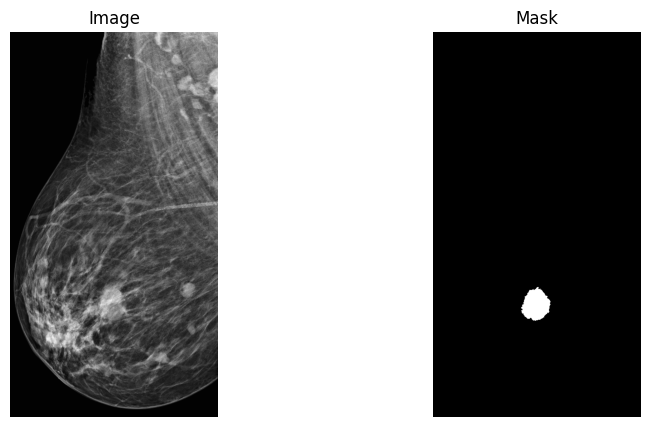

Unique values in the mask: [0 1]


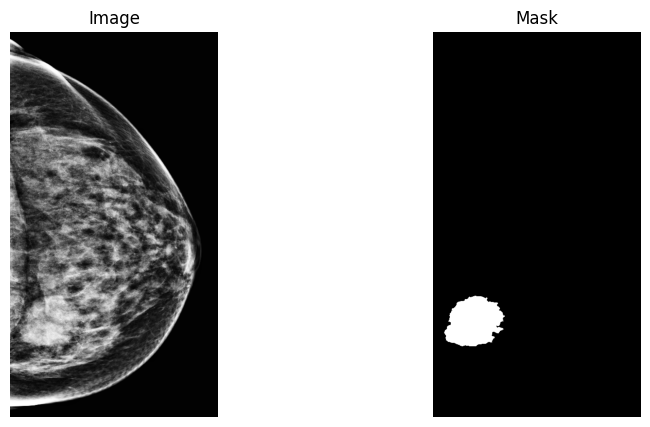

Unique values in the mask: [0 1]


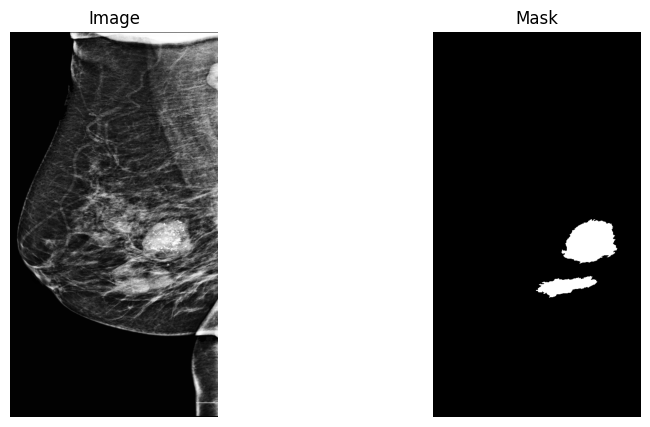

Unique values in the mask: [0 1]


In [22]:
show_img_mask(dataset=train_dataset, batch=3, image_number=2)

### **Define the Unet Model**

Simple Unet model for single-class segmentation

In [23]:
from unet_models import unet_model, res_unet_model, VGG16_UNet, attention_unet_model, attention_res_unet_model

In [ ]:
def get_model(model_name):
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    
    if model_name == 'simple_unet':
        return unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'simple_resunet':
        return res_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'vgg_tl_unet': 
        return VGG16_UNet(num_classes=1, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dropout=0.1, batch_norm=False) # VGG requires 3 channels
    elif model_name == 'attention_unet':
        return attention_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'attention_resunet':
        return attention_res_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    else:
        raise ValueError("Unknown model name")

**Compile Model**

test with 
* different optimizers - adam, rmsprop, sgd
* loss functions - binary_crossentropy, iou/jaccard loss, dice loss, combined iou and dice loss, focal loss
* metrics - iou/jaccard, dice coefficient, Fscore

In [25]:
from loss_and_metrics import jaccard_coef, jaccard_loss, dice_coef, dice_loss, combined_jaccard_dice_loss, focal_loss, specificity, precision, recall, f1score

with strategy.scope():
    model = get_model()
        
    metrics = [f1score, specificity, jaccard_coef, dice_coef]
    if loss_name == 'combined_jaccard_dice_loss':
        loss_function = combined_jaccard_dice_loss(alpha=0.5)
    elif loss_name == 'jaccard_loss':
        loss_function = jaccard_loss
    elif loss_name == 'dice_loss':
        loss_function = dice_loss
    elif loss_name == 'focal_loss':
        loss_function = focal_loss
    elif loss_name == 'binary':
        loss_function = 'binary_crossentropy'
    else:
        raise ValueError('Invalid loss function')

    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)

    model.summary()       

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 432, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 432, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 800, 432, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 800, 432, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
import visualkeras

model = model

visualkeras.layered_view(model).show()

**Train the model**

In [28]:
checkpoint_path = logs_directory + '{}_best.hdf5'.format(model_name)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=7, 
                               verbose=1, 
                               mode='min')

In [29]:
# If starting with pre-trained weights. 
# model.load_weights('???.hdf5')

epochs = 150

start_time = time.time()

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    validation_data=test_dataset, 
                    verbose=1, 
                    shuffle=False,
                    callbacks=[model_checkpoint, early_stopping]
                   )

end_time = time.time()

training_time = end_time - start_time

model.save(logs_directory + '{}.hdf5'.format(model_name))

history_file = results_dir + '{}_history.json'.format(model_name)

with open(history_file, 'w') as f:
    json.dump(history.history, f)

Epoch 1/150


: 

In [ ]:
print(f"Training time: {training_time} seconds")

### **Evaluations**

**Accuracy and Loss**

In [ ]:
loss_val, acc, f1, spec, iou, dice = model.evaluate(test_dataset)

content = f"""
Loss: {loss_val}
Accuracy: {acc}
F1-Score: {f1}
Specificity: {spec}
IoU / Jaccard Coeff: {iou}
Dice Coeff: {dice}
"""

print(content)

In [ ]:
#plot the training and validation accuracy and loss at each epoch

fig, axs = plt.subplots(1, 4, figsize=(20, 8))

# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation Jaccard Coef
jc = history.history['jaccard_coef']
val_jc = history.history['val_jaccard_coef']
axs[1].plot(epochs, jc, 'y', label='Training Jacard Coeff.')
axs[1].plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
axs[1].set_title('Training and validation Jacard')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Jacard Coefficient')
axs[1].legend()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']
axs[2].plot(epochs, dice, 'y', label='Training Dice Coeff.')
axs[2].plot(epochs, val_dice, 'r', label='Validation Dice Coeff.')
axs[2].set_title('Training and validation Dice')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

fs = history.history['f1score']
val_fs = history.history['val_f1score']
axs[3].plot(epochs, fs, 'y', label='F1score')
axs[3].plot(epochs, val_fs, 'r', label='F1score')
axs[3].set_title('Training and validation F1score')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('F1score')
axs[3].legend()

plt.show()

fig.savefig(os.path.join(results_dir, 'training_validation_metrics.png'))

**Best Model**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(checkpoint_path, compile=False)  

model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)

In [ ]:
loss, accuracy, f1score, specificity, iou, dice = model.evaluate(test_dataset)

content = f"""
---------------------------------------------
Model: {model_name}
---------------------------------------------
Loss Function: {loss_name}

Training completed in: {training_time} seconds

Loss: {loss}
Accuracy: {accuracy}
F1-Score: {f1score}
Specificity: {specificity}
IoU / Jaccard Coeff: {iou}
Dice Coeff: {dice}
"""

print(content)

filename = os.path.join(results_dir, 'model_evaluation_results.txt')

with open(filename, 'w') as file:
    file.write(content)

print("The evaluation metrics have been saved to:", filename)

**Average IoU Score**

In [ ]:
threshold=0.7

In [ ]:
def calculate_batch_iou(true_mask, pred_mask):
    ious = []
    
#     pred_mask = tf.math.round(pred_mask)  # convert pred probs to binary preds (0 or 1)
    pred_mask = tf.cast(pred_mask > threshold, tf.float32)
    true_mask = tf.cast(true_mask, tf.float32)

    intersection = tf.math.logical_and(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    union = tf.math.logical_or(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    iou = tf.reduce_sum(tf.cast(intersection, tf.float32)) / tf.reduce_sum(tf.cast(union, tf.float32))
    ious.append(iou)

    return tf.stack(ious)

In [ ]:
total_iou = 0.0
total_batches = 0

for images, masks in test_dataset:
    preds = model.predict(images)
    batch_iou = calculate_batch_iou(masks, preds)
    total_iou += batch_iou
    total_batches += 1

mean_iou = total_iou / total_batches

mean_iou_content = f"Mean IoU = {mean_iou.numpy()}"

print(mean_iou_content)

with open(filename, 'a') as file:
    file.write('\n' + mean_iou_content)

print("Mean IoU has been added to:", filename)

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_true_labels = []
all_predicted_labels = []

for images, masks in test_dataset:
    y_pred = model.predict(images)
    
    # y_pred = tf.math.round(y_pred)  # convert pred probs to binary preds (0 or 1)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(masks, tf.float32)
    
    all_predicted_labels.extend(y_pred.numpy().flatten())
    all_true_labels.extend(y_true.numpy().flatten())
    
    del y_pred, y_true
    gc.collect()

cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(6, 4))

class_names = ['Background', 'Lesion']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()
plt.clf()

## **Predictions**

**Predict on Test Image**

In [ ]:
def check_predictions(dataset, batch, img):
    for images, masks in dataset.take(batch):

        predicted_masks = model.predict(images)

        # predicted_masks = tf.math.round(predicted_masks)
        predicted_masks = tf.cast(predicted_masks > threshold, tf.float32)

        true_masks = tf.cast(masks, tf.float32)
        
        iou = calculate_batch_iou(true_masks[img], predicted_masks[img])

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(images[img])
        plt.title("Original Image")

        plt.subplot(132)
        plt.imshow(true_masks[img], cmap='jet')
        plt.title("Ground Truth")

        plt.subplot(133)
        plt.imshow(predicted_masks[img], cmap='jet')
        plt.title(f"Predicted Image = IoU: {iou}")
        
        plt.savefig(os.path.join(results_dir, 'predictions_on_test_image.png'))

        plt.show()
    
        plt.clf()
        
check_predictions(dataset=test_dataset, batch=2, img=3)

**Predict on Unseen Data**

In [ ]:
def predict_single_image_mask(model, image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    image, mask = wrap_preprocessing(image, mask)
    image = tf.image.resize(image, image_size)
    image = image / 255
    mask = tf.image.resize(mask, image_size, method='nearest')
    mask = tf.math.round(mask / mask_gray_value)
    
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    
    predicted_mask = model.predict(image)
    
    # predicted_mask = tf.math.round(predicted_mask)
    predicted_mask = tf.cast(predicted_mask > threshold, tf.float32)
    iou = calculate_batch_iou(mask, predicted_mask)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title("Original Image")

    plt.subplot(132)
    plt.imshow(mask[0], cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(133)
    plt.imshow(predicted_mask[0], cmap='jet')
    plt.title(f"Predicted Image - IoU: {iou}")
    
    plt.savefig(os.path.join(results_dir, 'predictions_on_unseen_image.png'))
    
    plt.show()
    
    plt.clf()
    
predict_single_image_mask(model, image_files_unseen, mask_files_unseen)

In [ ]:
# def predict_single_image(model, image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=1)
#     image, _ = wrap_preprocessing(image, np.zeros(image.shape))
#     image = tf.image.resize(image, image_size)
#     image = image / 255
    
#     image = tf.expand_dims(image, axis=0)
    
#     predicted_mask = model.predict(image)
    
#     predicted_mask = tf.math.round(predicted_mask)
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(image[0])
#     plt.title("Original Image")
    
#     plt.subplot(122)
#     plt.imshow(predicted_mask[0], cmap='jet')
#     plt.title("Predicted Image")
    
#     plt.show()

# image_path = '/kaggle/input/unseen/0248-LCC.png'
# predict_single_image(model, image_path)